In [ ]:
# 1)

# Importar Librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Importar Dataset
database = pd.read_csv('diabetes.csv')

# Usar TODAS as features, não apenas três. O modelo deve decidir o que é importante.
X = database.drop('Outcome', axis=1)
y = database['Outcome']

# Problema crítico neste dataset: valores '0' em colunas onde isso é impossível
# (ex: pressão sanguínea, glicose, IMC). Eles são, na verdade, dados ausentes.
# Vamos substituí-los por NaN (Not a Number) para que possamos tratá-los.
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
X[cols_with_zeros] = X[cols_with_zeros].replace(0, np.nan)

#Dividir em conjunto de treinamento e conjunto de teste
from sklearn.model_selection import train_test_split

# Dividir os dados. shuffle=True é crucial.
# stratify=y garante que a proporção de diabéticos/não-diabéticos seja a mesma nos conjuntos de treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [ ]:
# RandomForestClassifier é um "ensemble" de árvores de decisão.
# Ele é mais robusto, menos propenso a overfitting e geralmente mais preciso.
model = RandomForestClassifier(random_state=42)

# Um Pipeline automatiza e organiza as etapas de transformação dos dados
# Criamos as etapas do nosso pipeline:
# 1. 'imputer': Preenche os valores NaN (os zeros que substituímos) com a média da coluna.
# 2. 'scaler': Padroniza as features para que tenham média 0 e desvio padrão 1.
# 3. 'classifier': O nosso modelo de classificação.
full_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', model)
])

# Defina o grid de parâmetros para pesquisar
param_grid = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 2, 4]
}

 # Executar pesquisa em grade com cross validation
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

 # Melhor combinação de parâmetros
print(f'Best hyperparameters: {grid_search.best_params_}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 100}


In [ ]:
# Aplique os melhores parâmetros ao modelo final da Árvore de Decisão
DTmodel = grid_search.best_estimator_

 # Treine o modelo de árvore de decisão com os melhores parâmetros
DTmodel.fit(X_train, y_train)

 # Faça previsões usando o modelo de árvore de decisão
y_pred_DT = DTmodel.predict(X_test)

 # Avalie o desempenho do modelo de árvore de decisão
accuracyDT = accuracy_score(y_test, y_pred_DT)
print(f'Acurácia do modelo: {accuracyDT}')

Model accuracy: 0.7402597402597403


--- Matriz de Confusão ---


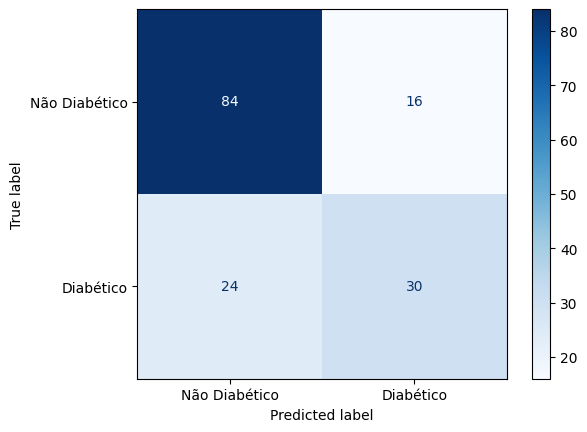

In [ ]:
# O grid_search já treina o melhor modelo com todos os dados de treino.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# A Matriz de Confusão nos mostra exatamente onde o modelo acertou e errou.
print("--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Diabético', 'Diabético'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# 2)

# --- 1. Importar Bibliotecas ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

database = pd.read_csv('housing_prices_California.csv')

# Separar o alvo (y) das features (X)
X = database.drop('median_house_value', axis=1)
y = database['median_house_value'].copy()

# Criar novas features que podem ter maior poder preditivo
X['rooms_per_household'] = X['total_rooms'] / X['households']
X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
X['population_per_household'] = X['population'] / X['households']

# Identificar colunas numéricas e categóricas
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['ocean_proximity']

# Pipeline para dados numéricos:
# 1. SimpleImputer: Preenche valores faltantes (NaN) com a mediana da coluna
# 2. StandardScaler: Coloca todas as features na mesma escala (muito importante para muitos algoritmos)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para dados categóricos:
# 1. OneHotEncoder: Transforma a coluna de texto 'ocean_proximity' em colunas numéricas (0s e 1s)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar os pipelines de pré-processamento para os diferentes tipos de colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 5. Escolha do Modelo e Separação dos Dados ---
# RandomForestRegressor é uma excelente alternativa ao SVR: mais rápido para treinar e muitas vezes mais preciso.
model = RandomForestRegressor(random_state=42)

# Combinar pré-processador e modelo em um único pipeline final
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', model)])

# Dividir os dados em treino e teste. shuffle=True é essencial para garantir amostras representativas.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# RandomizedSearchCV é mais rápido que GridSearchCV e encontra ótimos resultados.

# Definir a grade de parâmetros para a busca
# Usamos notações como 'regressor__n_estimators' para acessar os parâmetros do modelo dentro do pipeline
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# n_iter: número de combinações a testar. cv: número de folds na validação cruzada.
# n_jobs=-1: usa todos os processadores do seu computador.
random_search = RandomizedSearchCV(full_pipeline, param_distributions=param_dist, n_iter=20, cv=5,
                                   scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)

print("Iniciando a busca por hiperparâmetros...")
random_search.fit(X_train, y_train)

print(f"\nMelhores hiperparâmetros encontrados: {random_search.best_params_}")

# Usar o melhor modelo encontrado pela busca
best_model = random_search.best_estimator_

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Calcular métricas de avaliação
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Resultados da Avaliação no Conjunto de Teste ---")
print(f"Erro Quadrático Médio (MSE): ${mse:,.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): ${rmse:,.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2%}")
print("-----------------------------------------------------")
print(f"\nExplicação: O RMSE indica que o modelo erra, em média, cerca de ${rmse:,.2f} nas suas previsões de valor de imóveis.")
print(f"O R² de {r2:.2%} significa que o modelo consegue explicar aproximadamente {r2:.0%} da variação nos preços dos imóveis.")

Iniciando a busca por hiperparâmetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhores hiperparâmetros encontrados: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'log2', 'regressor__max_depth': 30}

--- Resultados da Avaliação no Conjunto de Teste ---
Erro Quadrático Médio (MSE): $2,438,280,912.22
Raiz do Erro Quadrático Médio (RMSE): $49,378.95
Coeficiente de Determinação (R²): 81.39%
-----------------------------------------------------

Explicação: O RMSE indica que o modelo erra, em média, cerca de $49,378.95 nas suas previsões de valor de imóveis.
O R² de 81.39% significa que o modelo consegue explicar aproximadamente 81% da variação nos preços dos imóveis.
